## Access Satellite GHRSST L3S 1day Day and Night Single Sensor Australia data in Zarr
A jupyter notebook to show how to access and plot the AODN satellite_ghrsst_l3s_1day_daynighttime_single_sensor_australia dataset available as a [Zarr](https://zarr.dev/)  dataset on S3

In [1]:
dataset_name = "satellite_ghrsst_l3s_1day_daynighttime_single_sensor_australia"

In [2]:
import xarray as xr
import fsspec

## Install/Update packages and Load common functions

In [3]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():
    os.system(f'uv pip install --system -r {requirements_path}')
else:
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 230 packages in 32ms


In [4]:
import requests
import os
if not os.path.exists('parquet_queries.py'):
  print('Downloading parquet_queries.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/ParquetDataQuery.py'
  response = requests.get(url)
  with open('parquet_queries.py', 'w') as f:
      f.write(response.text)

In [5]:
from parquet_queries import plot_gridded_variable, create_timeseries,plot_time_coverage

In [6]:
# remote zarr dataset
url = f's3://aodn-cloud-optimised/{dataset_name}.zarr/'
ds = xr.open_zarr(fsspec.get_mapper(url, anon=True), consolidated=True)
ds

<xarray.Dataset> Size: 23TB
Dimensions:                  (time: 9713, lat: 4500, lon: 6000)
Coordinates:
  * lat                      (lat) float32 18kB 19.99 19.97 ... -69.97 -69.99
  * lon                      (lon) float32 24kB 70.01 70.03 ... 190.0 190.0
  * time                     (time) datetime64[ns] 78kB 2019-01-01T09:20:00 ....
Data variables:
    dt_analysis              (time, lat, lon) float64 2TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    l2p_flags                (time, lat, lon) float32 1TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    quality_level            (time, lat, lon) float32 1TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    satellite_zenith_angle   (time, lat, lon) float64 2TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sea_surface_temperature  (time, lat, lon) float64 2TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sses_bias                (time, lat, lon) float64 2TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sses_count               (time, lat, lon) float64 2TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sses_standard_deviation  (time, lat, lon) float64 2TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sst_count                (time, lat, lon) float64 2TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sst_dtime                (time, lat, lon) float64 2TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sst_mean                 (time, lat, lon) float64 2TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
    sst_standard_deviation   (time, lat, lon) float64 2TB dask.array<chunksize=(5, 1000, 1000), meta=np.ndarray>
Attributes: (12/50)
    Conventions:                      CF-1.6
    Metadata_Conventions:             Unidata Dataset Discovery v1.0
    Metadata_Link:                    TBA
    acknowledgment:                   Any use of these data requires the foll...
    cdm_data_type:                    grid
    comment:                          HRPT AVHRR experimental L3 retrieval pr...
    ...                               ...
    summary:                          A merged, day+night, multi-sensor L3S f...
    time_coverage_end:                20021009T000600Z
    time_coverage_start:              20021007T191706Z
    title:                            IMOS L3S Day and Night gridded multiple...
    uuid:                             9ac89e04-601f-46ef-b2c6-a5f8ede3b892
    westernmost_longitude:            70.01000213623047

## Plot time coverage

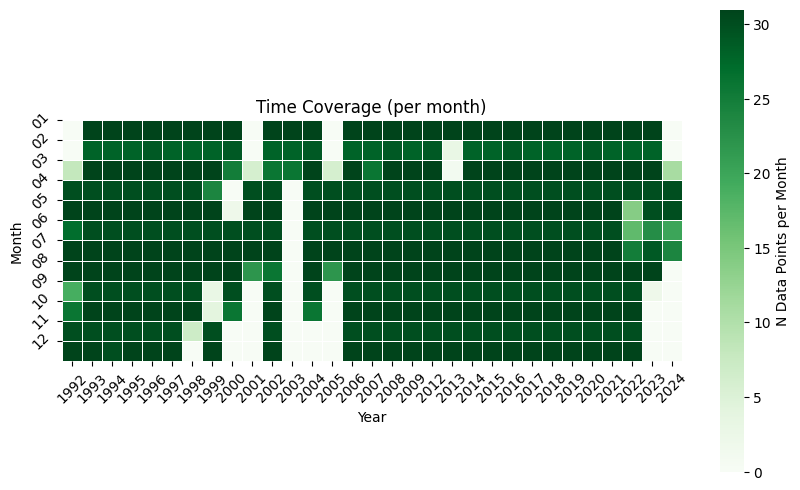

In [7]:
plot_time_coverage(ds)

## Timeseries at a point

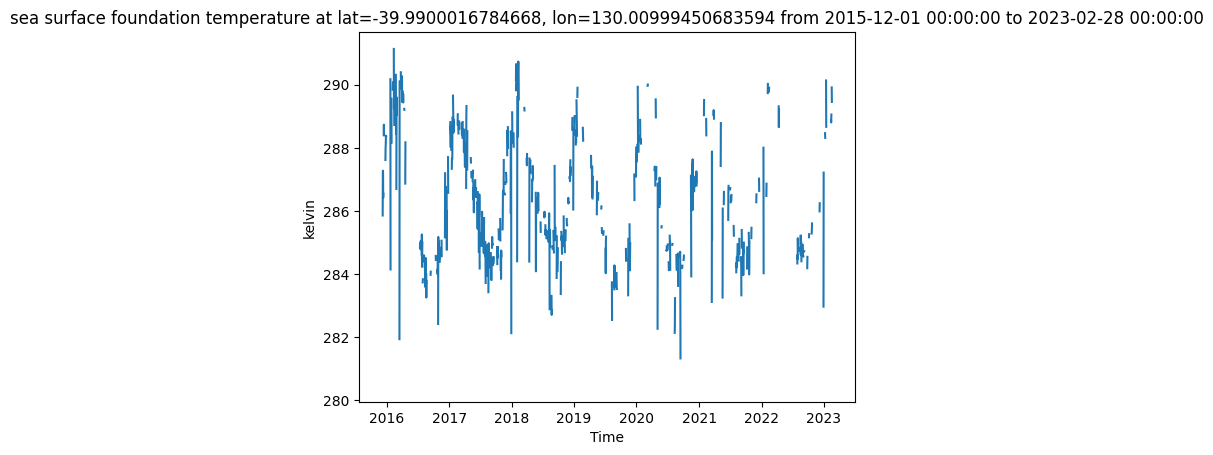

CPU times: user 1min 3s, sys: 17.8 s, total: 1min 21s
Wall time: 52.6 s


In [8]:
%%time
time_series_df = create_timeseries(ds, 'sea_surface_temperature', lat=-40, lon=130, start_time='2015-12-01', end_time='2023-02-28')

## Plot a gridded variable

Nearest date in dataset: <xarray.DataArray 'time' ()> Size: 8B
array('2019-06-02T09:20:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2019-06-02T09:20:00
Attributes:
    axis:           T
    comment:        A typical reference time for data
    long_name:      reference time of sst file
    standard_name:  time
Variable Long Name: sea surface foundation temperature


/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/parquet_queries.py:633: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


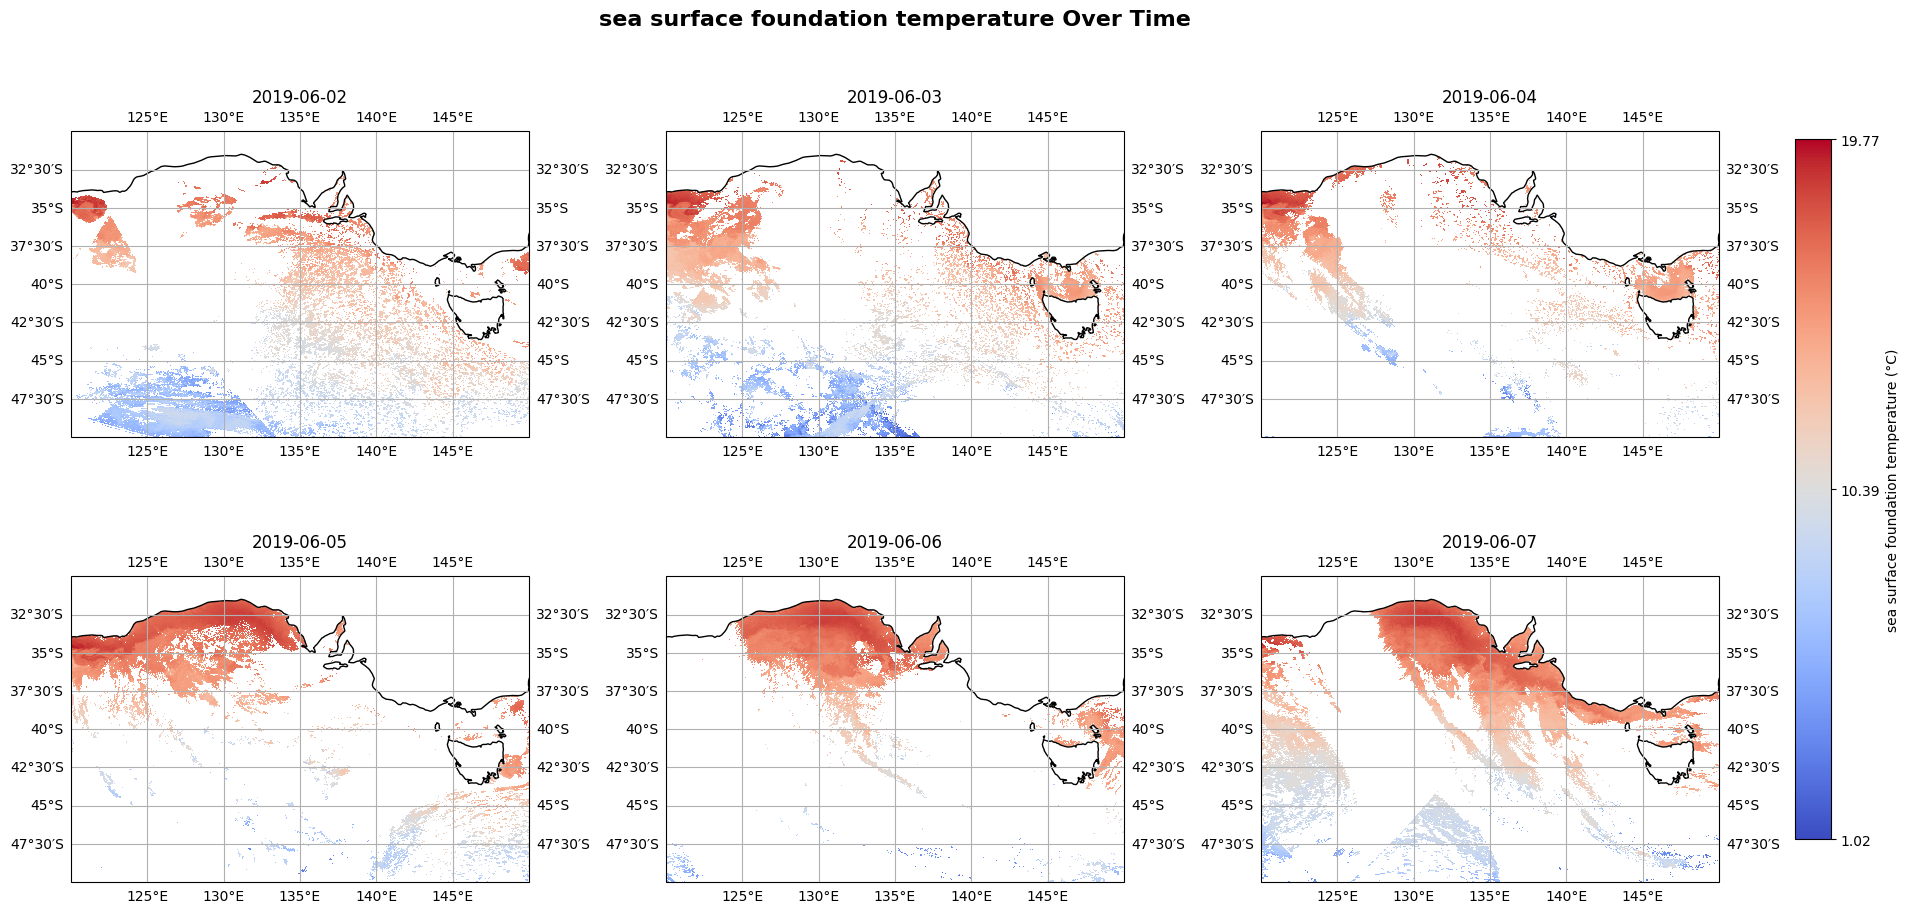

In [9]:
plot_gridded_variable(ds, start_date='2019-06-02', lon_slice=(120, 150), lat_slice=(-50, -30), var_name='sea_surface_temperature', n_days=6, coastline_resolution="50m")